### Importing libraries

In [1]:
from datetime import date, timedelta
from keras.models import Sequential
from keras.layers import LSTM, Dense
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as webreader
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
# get today's date for data extraction
today = date.today().strftime(r"%Y-%m-%d")
start_date = "2010-01-01"

# getting s&p500 market data to train on
stockname = "S&P500"
symbol = '^GSPC'
df = webreader.DataReader(symbol, start=start_date, end=today, data_source="yahoo")
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,1133.869995,1116.560059,1116.560059,1132.989990,3991400000,1132.989990
2010-01-05,1136.630005,1129.660034,1132.660034,1136.520020,2491020000,1136.520020
2010-01-06,1139.189941,1133.949951,1135.709961,1137.140015,4972660000,1137.140015
2010-01-07,1142.459961,1131.319946,1136.270020,1141.689941,5270680000,1141.689941
2010-01-08,1145.390015,1136.219971,1140.520020,1144.979980,4389590000,1144.979980
...,...,...,...,...,...,...
2021-04-19,4180.810059,4150.470215,4179.799805,4163.259766,3788020000,4163.259766
2021-04-20,4159.180176,4118.379883,4159.180176,4134.939941,4338230000,4134.939941
2021-04-21,4175.020020,4126.350098,4128.419922,4173.419922,3865820000,4173.419922


getting data we want to use

In [3]:
data = df.filter(['Close'])
np_data = data.values
# get num rows to split training data
training_data_length = math.ceil(len(np_data) * .80)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(np_data)


In [4]:
scaled_data

array([[0.03490794],
       [0.03602401],
       [0.03622004],
       ...,
       [0.9961901 ],
       [0.98403668],
       [0.99832422]])

### Data Preprocessing

In [5]:
# data pre-processing --> need to split the data into mini batches
train_data = scaled_data[0:training_data_length, :]

# Split the data into x_train and y_train data sets
x_train = []
y_train = []
trainingdatasize = len(train_data) 
for i in range(100, trainingdatasize):
    x_train.append(train_data[i-100: i, 0]) #contains 100 values 0-100
    y_train.append(train_data[i, 0]) #contains all other values

# Convert the x_train and y_train to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape)
print(y_train.shape)

(2177, 100, 1)
(2177,)


## Model Architecture

In [6]:
model = Sequential()

# Model with 100 nuerons - input shape = 100 timestamps
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))

# compile model
model.compile(optimizer='adam', loss='mean_squared_error')
print("model compiled")


model compiled


### Training the model

In [7]:
model.fit(x_train, y_train, batch_size=16, epochs=25)

Epoch 1/25
137/137 [==============================] - 7s 54ms/step - loss: 0.0039
Epoch 2/25
137/137 [==============================] - 7s 49ms/step - loss: 1.5531e-04
Epoch 3/25
137/137 [==============================] - 7s 48ms/step - loss: 1.4685e-04
Epoch 4/25
137/137 [==============================] - 6s 47ms/step - loss: 1.5289e-04
Epoch 5/25
137/137 [==============================] - 7s 48ms/step - loss: 1.5689e-04
Epoch 6/25
137/137 [==============================] - 7s 48ms/step - loss: 1.4802e-04
Epoch 7/25
137/137 [==============================] - 7s 48ms/step - loss: 1.2678e-04
Epoch 8/25
137/137 [==============================] - 7s 49ms/step - loss: 1.2492e-04
Epoch 9/25
137/137 [==============================] - 7s 48ms/step - loss: 1.2822e-04
Epoch 10/25
137/137 [==============================] - 7s 49ms/step - loss: 1.3309e-04
Epoch 11/25
137/137 [==============================] - 7s 49ms/step - loss: 1.4753e-04
Epoch 12/25
137/137 [==============================] - 7

### Getting test predictions

In [9]:
# Create a new array containing scaled test values
test_data = scaled_data[training_data_length - 100:, :]

# Create the data sets x_test and y_test
x_test = []
y_test = np_data[training_data_length:, :]
for i in range(100, len(test_data)):
    x_test.append(test_data[i-100:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data, so that we get an array with multiple test datasets
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [11]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [12]:
mae = mean_absolute_error(predictions, y_test)
print('MAE: ' + str(round(mae, 1)))
rmse = np.sqrt(np.mean(predictions - y_test) ** 2)
print('RMSE: ' + str(round(rmse, 1)))

MAE: 39.2
RMSE: 11.1


### Understanding the results:
- the model tends to predict on the pessimistic side, but in terms of the RMSE , it means that the predictions are mostly right for the most part.

### Visualizing the model's performance

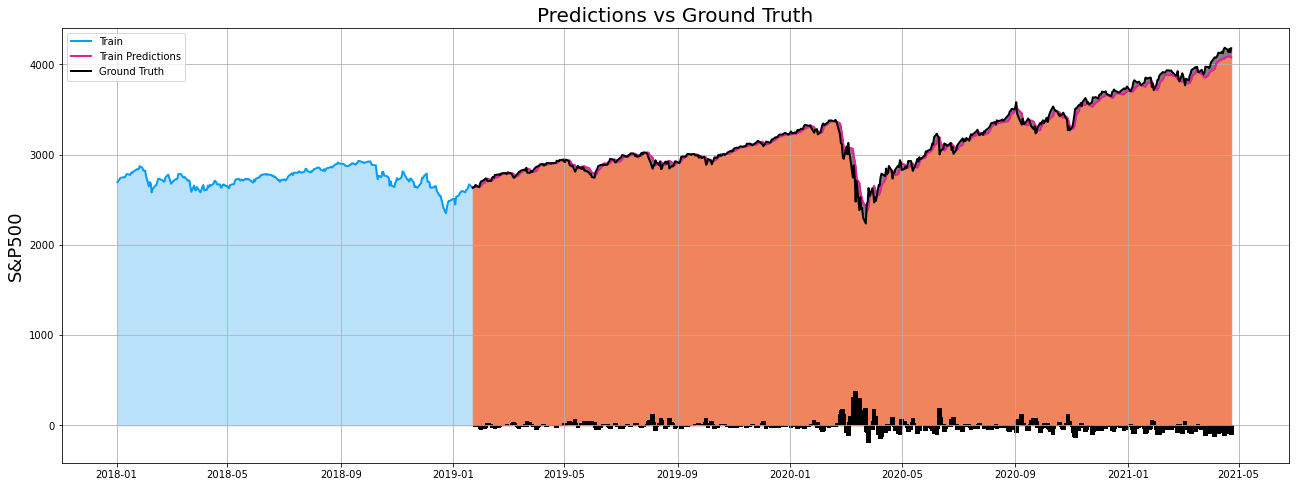

In [13]:
# The date from which on the date is displayed
display_start_date = "2018-01-01" 

# Add the difference between the valid and predicted prices
train = data[:training_data_length + 1]
valid = data[training_data_length:]
valid.insert(1, "Predictions", predictions, True)
valid.insert(1, "Difference", valid["Predictions"] - valid["Close"], True)

# Zoom in to a closer timeframe
valid = valid[valid.index > display_start_date]
train = train[train.index > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 8), sharex=True)
xt = train.index; yt = train[["Close"]]
xv = valid.index; yv = valid[["Close", "Predictions"]]
plt.title("Predictions vs Ground Truth", fontsize=20)
plt.ylabel(stockname, fontsize=18)
plt.plot(yt, color="#039dfc", linewidth=2.0)
plt.plot(yv["Predictions"], color="#E91D9E", linewidth=2.0)
plt.plot(yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Train Predictions", "Ground Truth"], loc="upper left")

# Fill between plotlines
ax1.fill_between(xt, 0, yt["Close"], color="#b9e1fa")
ax1.fill_between(xv, 0, yv["Predictions"], color="#F0845C")
ax1.fill_between(xv, yv["Close"], yv["Predictions"], color="grey") 

# Create the bar plot with the differences
x = valid.index
y = valid["Difference"]
plt.bar(x, y, width=5, color="black")
plt.grid()
plt.show()

## Predicting a single day ahead

In [19]:
# Get fresh data until today and create a new dataframe with only the price data
price_quote = webreader.DataReader(symbol, data_source='yahoo', start=start_date, end=today)
new_df = price_quote.filter(['Close'])

# Get the last 100 day closing price values and scale the data to be values between 0 and 1
last_100_days = new_df[-100:].values
last_100_days_scaled = scaler.transform(new_df[-100:].values)

# Create an empty list and Append past 100 days
X_test = []
X_test.append(last_100_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Get the predicted scaled price, undo the scaling and output the predictions
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
date_tomorrow = date.today() + timedelta(days=1)
print('The price for ' + stockname + ' at ' + today + ' was: ' + str(round(df.at[df.index.max(), 'Close'])))
print('The predicted ' + stockname + ' price at date ' + str(date_tomorrow) + ' is: ' + str(round(pred_price[0, 0], 0)))

The price for S&P500 at 2021-04-25 was: 4180
The predicted S&P500 price at date 2021-04-26 is: 4085.0


## Serializing the model

In [21]:
model.save("s&p500_model")
model.save_weights("s&p500_model_weights.h5")

## to load: 
#from tensorflow import keras
#my_model = keras.models.load_model('s&p500_model')
#my_model.load_weights("s&p500_model_weights.h5")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: s&p500_model\assets
